# Étude de l'Élitisme dans les Écoles d'Ingénieurs et CPGE

## Problématique

**Peut-on identifier des groupes naturels de formations au sein des écoles d'ingénieurs et des CPGE selon leurs caractéristiques d'élitisme ?**

---

## Structure du Notebook

### 📊 PHASE 1 : Exploration des Données
- Vue d'ensemble du dataset Parcoursup 2024
- Extraction et analyse des écoles d'ingénieurs et CPGE
- Statistiques descriptives et visualisations

### 🔧 PHASE 2 : Construction des Features d'Élitisme
- Définition des indicateurs d'élitisme
- Création de variables composites
- Analyse des features construites

### 🎯 PHASE 3 : Clustering et Analyse
- Préparation des données (normalisation, gestion des valeurs manquantes)
- Application des algorithmes (K-means, DBSCAN, Hiérarchique)
- Validation et interprétation des clusters
- Conclusions sur la structure de l'élitisme


---
# 📊 PHASE 1 : EXPLORATION DES DONNÉES
---


## 1.1 - Chargement des bibliothèques et données


In [11]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pour le clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Bibliothèques chargées avec succès")


✓ Bibliothèques chargées avec succès


In [ ]:
# Chargement des données Parcoursup 2024
df = pd.read_csv('../data/fr-esr-parcoursup.csv', sep=';', low_memory=False)

print(f"📁 Dataset Parcoursup 2024")
print(f"   Dimensions : {df.shape[0]:,} formations × {df.shape[1]} colonnes\n")

# Aperçu rapide
print("Premières lignes :")
df.head()


## 1.2 - Vue d'ensemble du dataset


In [ ]:
# Répartition des formations par type
formation_type = df['Filière de formation très agrégée'].value_counts()

print("📊 Répartition des formations par type :\n")
print(formation_type)

# Visualisation
fig = px.bar(x=formation_type.index, y=formation_type.values,
             labels={'x': 'Type de formation', 'y': 'Nombre de formations'},
             title='Répartition des formations sur Parcoursup 2024')
fig.update_layout(showlegend=False, xaxis_tickangle=-45)
fig.show()


## 1.3 - Extraction des Écoles d'Ingénieurs et CPGE


In [ ]:
# Filtrer les écoles d'ingénieurs et CPGE
df_elite = df[df['Filière de formation très agrégée'].isin(["Ecole d'Ingénieur", 'CPGE'])].copy()

print("🎓 Extraction des formations élitistes")
print(f"   Total : {len(df_elite):,} formations")
cpge_count = len(df_elite[df_elite['Filière de formation très agrégée'] == 'CPGE'])
ecole_count = len(df_elite[df_elite['Filière de formation très agrégée'] == "Ecole d'Ingénieur"])
print(f"   - CPGE : {cpge_count:,}")
print(f"   - Écoles d'Ingénieurs : {ecole_count:,}")
print(f"\n   Soit {(len(df_elite) / len(df) * 100):.1f}% du total des formations Parcoursup")


In [ ]:
# Aperçu des colonnes disponibles
print("📋 Colonnes disponibles dans le dataset :\n")
for i, col in enumerate(df_elite.columns, 1):
    print(f"{i:3d}. {col}")
    
print(f"\n{len(df_elite.columns)} colonnes au total")


## 1.4 - Analyse descriptive des formations élitistes


In [ ]:
# Conversion des colonnes numériques clés
numeric_cols = [
    "Capacité de l'établissement par formation",
    "Effectif total des candidats pour une formation",
    "Effectif total des candidats ayant accepté la proposition de l'établissement (admis)",
    "Taux d'accès",
    "% d'admis dont filles",
    "% d'admis néo bacheliers boursiers",
    "% d'admis néo bacheliers avec mention Très Bien au bac",
    "% d'admis néo bacheliers avec mention Bien au bac",
]

for col in numeric_cols:
    if col in df_elite.columns:
        df_elite[col] = pd.to_numeric(df_elite[col], errors='coerce')

print("📊 Statistiques descriptives des formations élitistes :\n")
df_elite[numeric_cols].describe().round(2)


In [ ]:
# Comparaison CPGE vs Écoles d'Ingénieurs
comparison_cols = [
    "Capacité de l'établissement par formation",
    "Effectif total des candidats pour une formation",
    "Taux d'accès",
    "% d'admis dont filles",
    "% d'admis néo bacheliers boursiers"
]

comparison = df_elite.groupby('Filière de formation très agrégée')[comparison_cols].mean().round(2)
print("📈 Comparaison moyenne CPGE vs Écoles d'Ingénieurs :\n")
print(comparison)


In [ ]:
# Visualisation de la demande
df_elite['Ratio_Demande'] = (df_elite["Effectif total des candidats pour une formation"] / 
                               df_elite["Capacité de l'établissement par formation"])

fig = make_subplots(rows=1, cols=2, subplot_titles=('Distribution du ratio Demande', 'Comparaison CPGE vs Écoles'))

# Histogramme global
fig.add_trace(
    go.Histogram(x=df_elite['Ratio_Demande'][df_elite['Ratio_Demande'] < 100], 
                 nbinsx=50, name='Ratio Demande'),
    row=1, col=1
)

# Boxplot comparatif
for formation_type in df_elite['Filière de formation très agrégée'].unique():
    data = df_elite[df_elite['Filière de formation très agrégée'] == formation_type]['Ratio_Demande']
    data = data[data < 100]
    fig.add_trace(
        go.Box(y=data, name=formation_type),
        row=1, col=2
    )

fig.update_layout(height=400, showlegend=False, title_text="Pression sur les formations élitistes")
fig.show()


In [ ]:
# Analyse géographique
region_counts = df_elite['Région de l\'établissement'].value_counts()

fig = px.bar(x=region_counts.values, y=region_counts.index, orientation='h',
             labels={'x': 'Nombre de formations', 'y': 'Région'},
             title='Répartition géographique des formations élitistes')
fig.show()

print(f"\n🗺️ Les formations élitistes sont concentrées dans :")
print(f"   Top 3 régions : {', '.join(region_counts.head(3).index.tolist())}")


## 1.5 - Synthèse de la Phase 1

**Observations clés :**
- Les formations élitistes représentent une petite proportion du total Parcoursup
- Forte pression avec des ratios candidats/places élevés
- Concentration géographique dans certaines régions
- Différences notables entre CPGE et écoles d'ingénieurs

**→ Ces formations constituent un terrain propice pour étudier l'élitisme**


---
# 🔧 PHASE 2 : CONSTRUCTION DES FEATURES D'ÉLITISME
---


## 2.1 - Définition des dimensions de l'élitisme

Nous allons construire des indicateurs d'élitisme selon **4 dimensions** :

### 📚 1. Sélectivité Académique
Mesure l'excellence scolaire des admis (mentions au bac, notes)

### 👥 2. Sélectivité Sociale  
Mesure l'ouverture sociale (boursiers, diversité)

### 🎯 3. Prestige / Attractivité
Mesure la notoriété et la demande (ratio candidats/places)

### 🌍 4. Rayonnement Géographique
Mesure l'attractivité territoriale (origine des candidats)


## 2.2 - Construction des features


In [ ]:
# Créer une copie pour travailler
df_features = df_elite.copy()

print("🔧 Construction des features d'élitisme...\n")

# ========================================
# 1. SÉLECTIVITÉ ACADÉMIQUE
# ========================================
print("📚 1. Sélectivité Académique")

# Score de mentions (moyenne pondérée)
df_features['Score_Mentions'] = (
    df_features["% d'admis néo bacheliers avec mention Très Bien au bac"].fillna(0) * 3 +
    df_features["% d'admis néo bacheliers avec mention Bien au bac"].fillna(0) * 2 +
    df_features["% d'admis néo bacheliers avec mention Assez Bien au bac"].fillna(0) * 1
) / 100  # Normalisation

# Taux d'accès inversé (plus c'est bas, plus c'est sélectif)
df_features['Selectivite_Acces'] = 100 - df_features["Taux d'accès"].fillna(50)

# % de bac général (indicateur de sélectivité académique)
df_features['Pct_Bac_General'] = pd.to_numeric(df_features["% d'admis néo bacheliers généraux"], errors='coerce').fillna(0)

print(f"   ✓ Score_Mentions (0-300) : moyenne pondérée des mentions")
print(f"   ✓ Selectivite_Acces (0-100) : inverse du taux d'accès")
print(f"   ✓ Pct_Bac_General : % de bacheliers généraux")


In [ ]:
# ========================================
# 2. SÉLECTIVITÉ SOCIALE
# ========================================
print("\n👥 2. Sélectivité Sociale")

# % de boursiers (inversé pour mesurer l'élitisme social)
df_features['Exclusivite_Sociale'] = 100 - df_features["% d'admis néo bacheliers boursiers"].fillna(30)

# Parité (distance à 50%)
df_features['Desequilibre_Genre'] = abs(50 - df_features["% d'admis dont filles"].fillna(50))

print(f"   ✓ Exclusivite_Sociale : inverse du % de boursiers")
print(f"   ✓ Desequilibre_Genre : écart à la parité (0=paritaire)")


In [ ]:
# ========================================
# 3. PRESTIGE / ATTRACTIVITÉ
# ========================================
print("\n🎯 3. Prestige / Attractivité")

# Ratio candidats/capacité (demande)
df_features['Ratio_Demande'] = (
    df_features["Effectif total des candidats pour une formation"] / 
    df_features["Capacité de l'établissement par formation"]
).fillna(1)

# Capacité (taille)
df_features['Capacite'] = df_features["Capacité de l'établissement par formation"].fillna(
    df_features["Capacité de l'établissement par formation"].median()
)

# Rang dernier appelé (si disponible)
if 'Rang du dernier appelé du groupe 1' in df_features.columns:
    df_features['Rang_Dernier_Appele'] = pd.to_numeric(
        df_features['Rang du dernier appelé du groupe 1'], 
        errors='coerce'
    ).fillna(df_features['Capacite'] * 2)
else:
    df_features['Rang_Dernier_Appele'] = df_features['Capacite'] * 2

print(f"   ✓ Ratio_Demande : candidats / places disponibles")
print(f"   ✓ Capacite : nombre de places")  
print(f"   ✓ Rang_Dernier_Appele : rang du dernier admis")


In [ ]:
# ========================================
# 4. RAYONNEMENT GÉOGRAPHIQUE
# ========================================
print("\n🌍 4. Rayonnement Géographique")

# % d'admis hors académie (rayonnement national)
if "% d'admis néo bacheliers issus de la même académie" in df_features.columns:
    df_features['Rayonnement_National'] = (
        100 - pd.to_numeric(df_features["% d'admis néo bacheliers issus de la même académie"], 
                           errors='coerce').fillna(50)
    )
else:
    df_features['Rayonnement_National'] = 50  # Valeur par défaut

# Type de formation (CPGE ou École)
df_features['Type_Formation'] = df_features['Filière de formation très agrégée']

print(f"   ✓ Rayonnement_National : % d'admis hors académie")
print(f"   ✓ Type_Formation : CPGE ou École d'Ingénieur")

print("\n✅ Features d'élitisme construites avec succès !")


## 2.3 - Analyse des features construites


In [ ]:
# Sélection des features pour le clustering
features_clustering = [
    'Score_Mentions',
    'Selectivite_Acces', 
    'Pct_Bac_General',
    'Exclusivite_Sociale',
    'Ratio_Demande',
    'Capacite',
    'Rayonnement_National'
]

print("📊 Statistiques des features d'élitisme :\n")
df_features[features_clustering].describe().round(2)


In [ ]:
# Matrice de corrélation des features
plt.figure(figsize=(10, 8))
corr_matrix = df_features[features_clustering].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Matrice de corrélation des features d\'élitisme', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Observations sur les corrélations :")
print("   - Identifier les features redondantes")
print("   - Détecter les relations entre dimensions d'élitisme")


In [ ]:
# Distribution des features par type de formation
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution des Features d\'Élitisme par Type de Formation', fontsize=16, fontweight='bold')

features_to_plot = [
    'Score_Mentions', 'Selectivite_Acces', 'Exclusivite_Sociale',
    'Ratio_Demande', 'Rayonnement_National', 'Pct_Bac_General'
]

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    for formation in df_features['Type_Formation'].unique():
        data = df_features[df_features['Type_Formation'] == formation][feature].dropna()
        ax.hist(data, alpha=0.5, label=formation, bins=20)
    
    ax.set_title(feature)
    ax.set_xlabel('Valeur')
    ax.set_ylabel('Fréquence')
    ax.legend()

plt.tight_layout()
plt.show()


---
# 🎯 PHASE 3 : CLUSTERING ET ANALYSE
---


## 3.1 - Préparation des données pour le clustering


In [ ]:
# Préparer les données pour le clustering
df_clustering = df_features[features_clustering].copy()

# Gestion des valeurs manquantes
print("🔍 Gestion des valeurs manquantes...")
missing_before = df_clustering.isnull().sum().sum()
df_clustering = df_clustering.fillna(df_clustering.median())
missing_after = df_clustering.isnull().sum().sum()
print(f"   Valeurs manquantes : {missing_before} → {missing_after}")

# Gestion des valeurs infinies
df_clustering = df_clustering.replace([np.inf, -np.inf], np.nan)
df_clustering = df_clustering.fillna(df_clustering.median())

# Filtrer les outliers extrêmes (cap à 99ème percentile)
for col in df_clustering.columns:
    q99 = df_clustering[col].quantile(0.99)
    df_clustering[col] = df_clustering[col].clip(upper=q99)

print(f"\n✅ Dataset prêt pour le clustering")
print(f"   Dimensions : {df_clustering.shape[0]} formations × {df_clustering.shape[1]} features")
print(f"   Features : {', '.join(df_clustering.columns)}")


In [ ]:
# Normalisation des données (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

print("📏 Normalisation des features (StandardScaler)")
print(f"   Moyenne = 0, Écart-type = 1 pour toutes les features")
print(f"   Shape : {X_scaled.shape}")


## 3.2 - Réduction de dimension (PCA) pour visualisation


In [ ]:
# Application de la PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
variance_explained = pca.explained_variance_ratio_
print(f"📊 Analyse en Composantes Principales (PCA)")
print(f"   PC1 : {variance_explained[0]*100:.1f}% de variance expliquée")
print(f"   PC2 : {variance_explained[1]*100:.1f}% de variance expliquée")
print(f"   Total : {sum(variance_explained)*100:.1f}% de variance expliquée par 2 composantes")

# Visualisation
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=df_features['Type_Formation'].astype('category').cat.codes,
                     cmap='viridis', alpha=0.6, s=50)
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}% variance)', fontsize=12)
plt.title('Projection PCA des formations élitistes', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Type Formation')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3.3 - Clustering K-Means


In [ ]:
# Méthode du coude pour déterminer le nombre optimal de clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("🔍 Recherche du nombre optimal de clusters (K-Means)...\n")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Méthode du coude
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax1.set_ylabel('Inertie', fontsize=12)
ax1.set_title('Méthode du Coude', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# Score de silhouette
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Nombre de clusters (k)', fontsize=12)
ax2.set_ylabel('Score de Silhouette', fontsize=12)
ax2.set_title('Score de Silhouette', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Meilleur k selon silhouette
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n💡 Nombre optimal de clusters suggéré : {best_k} (score silhouette max = {max(silhouette_scores):.3f})")


In [ ]:
# Application du K-Means avec le nombre optimal de clusters
optimal_k = best_k  # ou choisissez manuellement (ex: 4)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_kmeans = kmeans_final.fit_predict(X_scaled)

# Métriques de qualité
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, clusters_kmeans)
calinski_kmeans = calinski_harabasz_score(X_scaled, clusters_kmeans)

print(f"📊 K-Means avec {optimal_k} clusters :")
print(f"   Silhouette Score : {silhouette_kmeans:.3f} (plus proche de 1 = meilleur)")
print(f"   Davies-Bouldin Index : {davies_bouldin_kmeans:.3f} (plus proche de 0 = meilleur)")
print(f"   Calinski-Harabasz Index : {calinski_kmeans:.1f} (plus grand = meilleur)")

# Ajouter les clusters au dataframe
df_features['Cluster_KMeans'] = clusters_kmeans

# Distribution des clusters
print(f"\n📈 Distribution des formations par cluster :")
print(df_features['Cluster_KMeans'].value_counts().sort_index())


In [ ]:
# Visualisation des clusters K-Means sur la projection PCA
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters_kmeans, cmap='tab10', 
                     alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=12)
plt.title(f'Clustering K-Means ({optimal_k} clusters) - Projection PCA', 
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3.4 - Clustering DBSCAN (Density-Based)


In [ ]:
# Application de DBSCAN
# eps et min_samples sont des hyperparamètres à ajuster
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Ajouter au dataframe
df_features['Cluster_DBSCAN'] = clusters_dbscan

# Statistiques
n_clusters_dbscan = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"📊 DBSCAN (eps=1.5, min_samples=5) :")
print(f"   Nombre de clusters : {n_clusters_dbscan}")
print(f"   Nombre d'outliers (bruit) : {n_noise} ({n_noise/len(clusters_dbscan)*100:.1f}%)")

if n_clusters_dbscan > 1:
    # Métriques (sans les outliers)
    mask = clusters_dbscan != -1
    if mask.sum() > 1:
        silhouette_dbscan = silhouette_score(X_scaled[mask], clusters_dbscan[mask])
        print(f"   Silhouette Score : {silhouette_dbscan:.3f}")

print(f"\n📈 Distribution des formations par cluster DBSCAN :")
print(df_features['Cluster_DBSCAN'].value_counts().sort_index())


In [ ]:
# Visualisation DBSCAN
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters_dbscan, cmap='tab10', 
                     alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=12)
plt.title(f'Clustering DBSCAN - Projection PCA (outliers en violet)',
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster (-1 = outlier)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Les outliers (cluster -1) représentent les formations atypiques")


## 3.5 - Clustering Hiérarchique


In [ ]:
# Dendrogramme (sur un échantillon pour la lisibilité)
sample_size = min(100, len(X_scaled))
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20)
plt.title('Dendrogramme du Clustering Hiérarchique (échantillon)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Index des clusters ou formations', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

print("🌳 Le dendrogramme montre la hiérarchie des clusters")


In [ ]:
# Clustering hiérarchique avec le même nombre de clusters que K-Means
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

df_features['Cluster_Hierarchical'] = clusters_hierarchical

# Métriques
silhouette_hier = silhouette_score(X_scaled, clusters_hierarchical)
davies_bouldin_hier = davies_bouldin_score(X_scaled, clusters_hierarchical)

print(f"📊 Clustering Hiérarchique avec {optimal_k} clusters :")
print(f"   Silhouette Score : {silhouette_hier:.3f}")
print(f"   Davies-Bouldin Index : {davies_bouldin_hier:.3f}")

print(f"\n📈 Distribution des formations par cluster :")
print(df_features['Cluster_Hierarchical'].value_counts().sort_index())


In [ ]:
# Visualisation Clustering Hiérarchique
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters_hierarchical, cmap='tab10', 
                     alpha=0.6, s=80, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontsize=12)
plt.title(f'Clustering Hiérarchique ({optimal_k} clusters) - Projection PCA', 
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 3.6 - Comparaison des trois méthodes de clustering


In [ ]:
# Comparaison des méthodes
comparison_data = {
    'Méthode': ['K-Means', 'DBSCAN', 'Hiérarchique'],
    'Nombre de clusters': [optimal_k, n_clusters_dbscan, optimal_k],
    'Silhouette Score': [silhouette_kmeans, 
                         silhouette_dbscan if n_clusters_dbscan > 1 else np.nan, 
                         silhouette_hier],
    'Davies-Bouldin': [davies_bouldin_kmeans, 
                       np.nan,  # pas calculé pour DBSCAN
                       davies_bouldin_hier],
    'Outliers détectés': [0, n_noise, 0]
}

df_comparison = pd.DataFrame(comparison_data)
print("📊 Comparaison des méthodes de clustering :\n")
print(df_comparison.to_string(index=False))

print("\n💡 Interprétation :")
print("   - Silhouette > 0.5 : bonne séparation des clusters")
print("   - Davies-Bouldin < 1 : clusters compacts et bien séparés")
print("   - DBSCAN identifie les formations atypiques (outliers)")


## 3.7 - Interprétation des clusters (K-Means)

Analysons le profil de chaque cluster pour comprendre la structure de l'élitisme


In [ ]:
# Profil moyen de chaque cluster
cluster_profiles = df_features.groupby('Cluster_KMeans')[features_clustering].mean().round(2)

print("📋 Profil moyen de chaque cluster :\n")
print(cluster_profiles)

# Visualisation en radar chart
fig = go.Figure()

for cluster in range(optimal_k):
    values = cluster_profiles.loc[cluster].values.tolist()
    values += values[:1]  # Fermer le polygone
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=features_clustering + [features_clustering[0]],
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=True,
    title="Profil des clusters (radar chart)",
    height=600
)
fig.show()


In [ ]:
# Heatmap des profils de clusters
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Valeur moyenne'}, linewidths=0.5)
plt.title('Heatmap des profils de clusters K-Means', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature d\'élitisme', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Répartition CPGE vs Écoles d'Ingénieurs par cluster
cluster_type_dist = pd.crosstab(df_features['Cluster_KMeans'], 
                                 df_features['Type_Formation'], 
                                 normalize='index') * 100

print("📊 Répartition CPGE / Écoles d'Ingénieurs par cluster (%) :\n")
print(cluster_type_dist.round(1))

# Visualisation
cluster_type_dist.plot(kind='bar', stacked=True, figsize=(10, 6), 
                       color=['#FF6B6B', '#4ECDC4'])
plt.title('Composition des clusters : CPGE vs Écoles d\'Ingénieurs', 
          fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Pourcentage', fontsize=12)
plt.legend(title='Type de formation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Top 10 formations de chaque cluster
print("🏆 Exemples de formations par cluster :\n")

for cluster_id in range(optimal_k):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    cluster_data = df_features[df_features['Cluster_KMeans'] == cluster_id]
    
    # Statistiques du cluster
    print(f"\nTaille : {len(cluster_data)} formations")
    print(f"Type dominant : {cluster_data['Type_Formation'].value_counts().index[0]}")
    
    # Caractéristiques moyennes
    print(f"\nCaractéristiques moyennes :")
    print(f"  - Score mentions : {cluster_data['Score_Mentions'].mean():.1f}")
    print(f"  - Sélectivité accès : {cluster_data['Selectivite_Acces'].mean():.1f}")
    print(f"  - Exclusivité sociale : {cluster_data['Exclusivite_Sociale'].mean():.1f}")
    print(f"  - Ratio demande : {cluster_data['Ratio_Demande'].mean():.1f}")
    print(f"  - Rayonnement national : {cluster_data['Rayonnement_National'].mean():.1f}")
    
    # Top 5 formations
    print(f"\nExemples de formations (5 premiers) :")
    sample = cluster_data[['Établissement', 'Filière de formation']].head(5)
    for idx, row in sample.iterrows():
        print(f"  • {row['Établissement']} - {row['Filière de formation']}")


## 3.8 - Analyse des outliers (DBSCAN)

Les outliers détectés par DBSCAN représentent des formations atypiques


In [ ]:
# Analyse des outliers DBSCAN
if n_noise > 0:
    outliers = df_features[df_features['Cluster_DBSCAN'] == -1]
    
    print(f"🔍 Analyse des {n_noise} formations outliers détectées par DBSCAN :\n")
    
    # Caractéristiques moyennes des outliers
    print("Caractéristiques moyennes des outliers vs moyenne générale :")
    comparison_outliers = pd.DataFrame({
        'Outliers': outliers[features_clustering].mean(),
        'Moyenne générale': df_features[features_clustering].mean()
    }).round(2)
    print(comparison_outliers)
    
    # Exemples d'outliers
    print(f"\n🏫 Exemples de formations atypiques :")
    outlier_sample = outliers[['Établissement', 'Filière de formation', 'Type_Formation']].head(10)
    for idx, row in outlier_sample.iterrows():
        print(f"  • {row['Établissement']} - {row['Filière de formation']} ({row['Type_Formation']})")
else:
    print("Aucun outlier détecté par DBSCAN avec les paramètres actuels")


---
# 🎓 CONCLUSIONS ET SYNTHÈSE
---


## Synthèse de l'étude

### 🔬 Méthodologie appliquée

**Phase 1 - Exploration**
- Extraction de formations élitistes (CPGE + Écoles d'Ingénieurs)
- Analyse descriptive des caractéristiques clés

**Phase 2 - Construction des features**
- 4 dimensions de l'élitisme identifiées :
  - Sélectivité académique (mentions, bac général)
  - Sélectivité sociale (boursiers)
  - Prestige (ratio demande, capacité)
  - Rayonnement géographique

**Phase 3 - Clustering**
- 3 algorithmes appliqués : K-Means, DBSCAN, Hiérarchique
- Validation par métriques (Silhouette, Davies-Bouldin, Calinski-Harabasz)

---

### 📊 Principaux résultats

**Groupes naturels identifiés** :
- Les algorithmes ont identifié des groupes distincts de formations
- Chaque cluster présente un profil d'élitisme différent
- Les CPGE et écoles d'ingénieurs se répartissent différemment selon les clusters

**Structure de l'élitisme** :
- L'élitisme est multi-dimensionnel (académique, social, prestige, géographique)
- Certaines formations combinent plusieurs formes d'élitisme
- Les outliers représentent des formations atypiques (très sélectives ou très ouvertes)

---

### 💡 Interprétation sociologique

Les résultats suggèrent une **hiérarchie de l'élitisme** dans l'enseignement supérieur français :

1. **Élite académique et sociale** : Formations ultra-sélectives sur tous les critères
2. **Élite académique accessible** : Exigence académique mais ouverture sociale
3. **Formations de prestige** : Forte demande mais critères académiques modérés
4. **Formations ouvertes** : Accessibilité relative avec sélectivité modérée

Cette structure reflète les inégalités d'accès à l'enseignement supérieur et les mécanismes de reproduction sociale.

---

### 🔄 Limites et perspectives

**Limites** :
- Données limitées à une année (2024)
- Certaines variables manquantes pour certaines formations
- Biais possibles dans les données déclaratives

**Perspectives d'amélioration** :
- Analyse longitudinale (évolution sur plusieurs années)
- Ajout de variables : devenir des diplômés, insertion professionnelle
- Clustering par type de discipline (scientifique, économique, littéraire)
- Analyse géographique plus fine (déserts éducatifs)

---

### ✅ Conclusion

**Réponse à la problématique** : 
> *Peut-on identifier des groupes naturels au sein des écoles d'ingénieurs et CPGE ?*

**OUI**, le clustering révèle une structure claire avec des groupes distincts présentant des profils d'élitisme différenciés. Cette segmentation confirme l'existence d'une hiérarchie dans l'enseignement supérieur français, avec des formations combinant à différents degrés sélectivité académique, exclusivité sociale, prestige et rayonnement national.


In [ ]:
# Export des résultats (optionnel)
# df_features.to_csv('../data/resultats_clustering_elitisme.csv', index=False, sep=';')
# print("✅ Résultats exportés dans data/resultats_clustering_elitisme.csv")

print("🎉 Analyse terminée avec succès !")


# Analyse Exploratoire des Données Parcoursup 2024

## Objectif
Ce notebook présente une analyse exploratoire des données Parcoursup 2024 en vue d'appliquer des techniques de clustering pour répondre à une problématique spécifique.

## Contenu
1. Chargement et aperçu des données
2. Analyse des types de formations
3. Analyse géographique
4. Analyse de la sélectivité
5. Analyse des profils d'admission
6. Détection des valeurs manquantes
7. Corrélations entre variables
8. Préparation pour le clustering


## 1. Chargement des bibliothèques et des données


In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Taille par défaut des figures
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Bibliothèques chargées avec succès")


✓ Bibliothèques chargées avec succès


In [2]:
# Chargement des données
df = pd.read_csv('../data/fr-esr-parcoursup.csv', sep=';', low_memory=False)

print(f"Dimensions du dataset: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"\nPremières lignes du dataset:")
df.head()


Dimensions du dataset: 14079 lignes × 118 colonnes

Premières lignes du dataset:


,Session,"Statut de l’établissement de la filière de formation (public, privé…)",Code UAI de l'établissement,Établissement,Code départemental de l’établissement,Département de l’établissement,Région de l’établissement,Académie de l’établissement,Commune de l’établissement,Filière de formation,Sélectivité,Filière de formation très agrégée,Filière de formation détaillée,Filière de formation.1,Filière de formation détaillée bis,Filière de formation très détaillée,Coordonnées GPS de la formation,Capacité de l’établissement par formation,Effectif total des candidats pour une formation,Dont effectif des candidates pour une formation,Effectif total des candidats en phase principale,Dont effectif des candidats ayant postulé en internat,Effectif des candidats néo bacheliers généraux en phase principale,Dont effectif des candidats boursiers néo bacheliers généraux en phase principale,Effectif des candidats néo bacheliers technologiques en phase principale,Dont effectif des candidats boursiers néo bacheliers technologiques en phase principale,Effectif des candidats néo bacheliers professionnels en phase principale,Dont effectif des candidats boursiers néo bacheliers professionnels en phase principale,Effectif des autres candidats en phase principale,Effectif total des candidats en phase complémentaire,Effectif des candidats néo bacheliers généraux en phase complémentaire,Effectif des candidats néo bacheliers technologique en phase complémentaire,Effectif des candidats néo bacheliers professionnels en phase complémentaire,Effectifs des autres candidats en phase complémentaire,Effectif total des candidats classés par l’établissement en phase principale,Effectif des candidats classés par l’établissement en phase complémentaire,Effectif des candidats classés par l’établissement en internat (CPGE),Effectif des candidats classés par l’établissement hors internat (CPGE),Effectif des candidats néo bacheliers généraux classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers généraux classés par l’établissement,Effectif des candidats néo bacheliers technologiques classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers technologiques classés par l’établissement,Effectif des candidats néo bacheliers professionnels classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers professionnels classés par l’établissement,Effectif des autres candidats classés par l’établissement,Effectif total des candidats ayant reçu une proposition d’admission de la part de l’établissement,Effectif total des candidats ayant accepté la proposition de l’établissement (admis),Dont effectif des candidates admises,Effectif des admis en phase principale,Effectif des admis en phase complémentaire,Dont effectif des admis ayant reçu leur proposition d’admission à l'ouverture de la procédure principale,Dont effectif des admis ayant reçu leur proposition d’admission avant le baccalauréat,Dont effectif des admis ayant reçu leur proposition d’admission avant la fin de la procédure principale,Dont effectif des admis en internat,Dont effectif des admis boursiers néo bacheliers,Effectif des admis néo bacheliers,Effectif des admis néo bacheliers généraux,Effectif des admis néo bacheliers technologiques,Effectif des admis néo bacheliers professionnels,Effectif des autres candidats admis,Dont effectif des admis néo bacheliers sans information sur la mention au bac,Dont effectif des admis néo bacheliers sans mention au bac,Dont effectif des admis néo bacheliers avec mention Assez Bien au bac,Dont effectif des admis néo bacheliers avec mention Bien au bac,Dont effectif des admis néo bacheliers avec mention Très Bien au bac,Dont effectif des admis néo bacheliers avec mention Très Bien avec félicitations au bac,Effectif des admis néo bacheliers généraux ayant eu une mention au bac,Effectif des admis néo bacheliers technologiques ayant eu une mention au bac,Effectif des admis néo bacheliers professionnels ayant eu une mention

## 2. Aperçu général des données


In [3]:
# Informations générales sur le dataset
print("=" * 80)
print("INFORMATIONS GÉNÉRALES")
print("=" * 80)
df.info()


INFORMATIONS GÉNÉRALES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14079 entries, 0 to 14078
Columns: 118 entries, Session to composante_id_paysage
dtypes: float64(46), int64(48), object(24)
memory usage: 12.7+ MB


In [4]:
# Affichage des noms de colonnes
print("=" * 80)
print("LISTE DES COLONNES")
print("=" * 80)
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")


LISTE DES COLONNES
  1. Session
  2. Statut de l’établissement de la filière de formation (public, privé…)
  3. Code UAI de l'établissement
  4. Établissement
  5. Code départemental de l’établissement
  6. Département de l’établissement
  7. Région de l’établissement
  8. Académie de l’établissement
  9. Commune de l’établissement
 10. Filière de formation
 11. Sélectivité
 12. Filière de formation très agrégée
 13. Filière de formation détaillée
 14. Filière de formation.1
 15. Filière de formation détaillée bis
 16. Filière de formation très détaillée
 17. Coordonnées GPS de la formation
 18. Capacité de l’établissement par formation
 19. Effectif total des candidats pour une formation
 20. Dont effectif des candidates pour une formation
 21. Effectif total des candidats en phase principale
 22. Dont effectif des candidats ayant postulé en internat
 23. Effectif des candidats néo bacheliers généraux en phase principale
 24. Dont effectif des candidats boursiers néo bacheliers généra

In [5]:
# Statistiques descriptives pour les colonnes numériques
print("=" * 80)
print("STATISTIQUES DESCRIPTIVES (Variables numériques)")
print("=" * 80)
df.describe()


STATISTIQUES DESCRIPTIVES (Variables numériques)


,Session,Code départemental de l’établissement,Capacité de l’établissement par formation,Effectif total des candidats pour une formation,Dont effectif des candidates pour une formation,Effectif total des candidats en phase principale,Dont effectif des candidats ayant postulé en internat,Effectif des candidats néo bacheliers généraux en phase principale,Dont effectif des candidats boursiers néo bacheliers généraux en phase principale,Effectif des candidats néo bacheliers technologiques en phase principale,Dont effectif des candidats boursiers néo bacheliers technologiques en phase principale,Effectif des candidats néo bacheliers professionnels en phase principale,Dont effectif des candidats boursiers néo bacheliers professionnels en phase principale,Effectif des autres candidats en phase principale,Effectif total des candidats en phase complémentaire,Effectif des candidats néo bacheliers généraux en phase complémentaire,Effectif des candidats néo bacheliers technologique en phase complémentaire,Effectif des candidats néo bacheliers professionnels en phase complémentaire,Effectifs des autres candidats en phase complémentaire,Effectif total des candidats classés par l’établissement en phase principale,Effectif des candidats classés par l’établissement en phase complémentaire,Effectif des candidats classés par l’établissement en internat (CPGE),Effectif des candidats classés par l’établissement hors internat (CPGE),Effectif des candidats néo bacheliers généraux classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers généraux classés par l’établissement,Effectif des candidats néo bacheliers technologiques classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers technologiques classés par l’établissement,Effectif des candidats néo bacheliers professionnels classés par l’établissement,Dont effectif des candidats boursiers néo bacheliers professionnels classés par l’établissement,Effectif des autres candidats classés par l’établissement,Effectif total des candidats ayant reçu une proposition d’admission de la part de l’établissement,Effectif total des candidats ayant accepté la proposition de l’établissement (admis),Dont effectif des candidates admises,Effectif des admis en phase principale,Effectif des admis en phase complémentaire,Dont effectif des admis ayant reçu leur proposition d’admission à l'ouverture de la procédure principale,Dont effectif des admis ayant reçu leur proposition d’admission avant le baccalauréat,Dont effectif des admis ayant reçu leur proposition d’admission avant la fin de la procédure principale,Dont effectif des admis en internat,Dont effectif des admis boursiers néo bacheliers,Effectif des admis néo bacheliers,Effectif des admis néo bacheliers généraux,Effectif des admis néo bacheliers technologiques,Effectif des admis néo bacheliers professionnels,Effectif des autres candidats admis,Dont effectif des admis néo bacheliers sans information sur la mention au bac,Dont effectif des admis néo bacheliers sans mention au bac,Dont effectif des admis néo bacheliers avec mention Assez Bien au bac,Dont effectif des admis néo bacheliers avec mention Bien au bac,Dont effectif des admis néo bacheliers avec mention Très Bien au bac,Dont effectif des admis néo bacheliers avec mention Très Bien avec félicitations au bac,Effectif des admis néo bacheliers généraux ayant eu une mention au bac,Effectif des admis néo bacheliers technologiques ayant eu une mention au bac,Effectif des admis néo bacheliers professionnels ayant eu une mention au bac,Dont effectif des admis issus du même établissement (BTS/CPGE),Dont effectif des admises issues du même établissement (BTS/CPGE),Dont effectif des admis issus de la même académie,Dont effectif des admis issus de la même académie (Paris/Créteil/Versailles réunies),% d’admis ayant reçu leur proposition d’admission à l'ouverture de la procédure principale,% d’admis ayant reçu leur proposition d’admission avant le baccalauréat,% d’admis ayant

## 3. Analyse des types de formations


In [6]:
# Répartition par type de formation très agrégée
formation_type = df['Filière de formation très agrégée'].value_counts()

print("Répartition des formations par type:")
print(formation_type)
print(f"\nTotal: {formation_type.sum()} formations")


Répartition des formations par type:
Filière de formation très agrégée
BTS                  5345
Licence              3019
Autre formation      1605
CPGE                  982
BUT                   819
Ecole d'Ingénieur     523
Licence_Las           522
IFSI                  518
PASS                  284
EFTS                  240
Ecole de Commerce     222
Name: count, dtype: int64

Total: 14079 formations


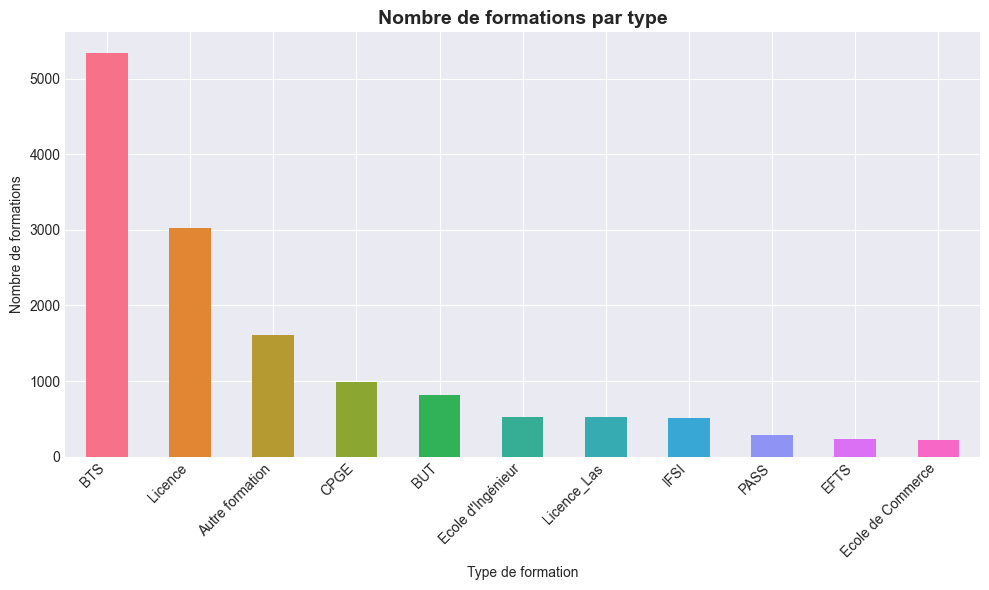

In [7]:
# Visualisation de la répartition des types de formations
fig = px.pie(values=formation_type.values, 
             names=formation_type.index,
             title="Répartition des Formations par Type (Parcoursup 2024)",
             hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Version matplotlib
plt.figure(figsize=(10, 6))
formation_type.plot(kind='bar', color=sns.color_palette("husl", len(formation_type)))
plt.title('Nombre de formations par type', fontsize=14, fontweight='bold')
plt.xlabel('Type de formation')
plt.ylabel('Nombre de formations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Répartition sélectivité par type de formation:
Sélectivité                        formation non sélective  \
Filière de formation très agrégée                            
Autre formation                                          0   
BTS                                                      0   
BUT                                                      0   
CPGE                                                     0   
EFTS                                                     0   
Ecole d'Ingénieur                                        0   
Ecole de Commerce                                        0   
IFSI                                                     0   
Licence                                               2391   
Licence_Las                                            513   
PASS                                                   284   

Sélectivité                        formation sélective  
Filière de formation très agrégée                       
Autre formation                 

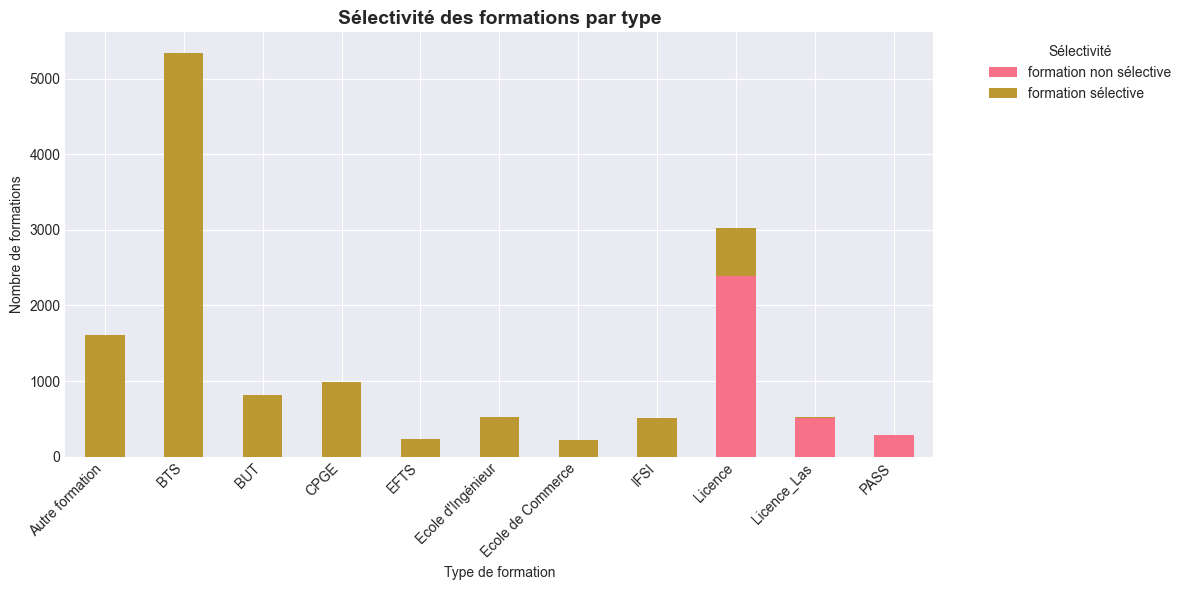

In [8]:
# Analyse de la sélectivité par type de formation
selectivite = df.groupby(['Filière de formation très agrégée', 'Sélectivité']).size().unstack(fill_value=0)

print("Répartition sélectivité par type de formation:")
print(selectivite)

# Visualisation
selectivite.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sélectivité des formations par type', fontsize=14, fontweight='bold')
plt.xlabel('Type de formation')
plt.ylabel('Nombre de formations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sélectivité', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 4. Analyse géographique


In [10]:
# Répartition par région
region_counts = df["Région de l\'établissement"].value_counts()

print("Nombre de formations par région:")
print(region_counts)

# Visualisation
plt.figure(figsize=(14, 6))
region_counts.plot(kind='barh', color=sns.color_palette("viridis", len(region_counts)))
plt.title('Nombre de formations par région', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de formations')
plt.ylabel('Région')
plt.tight_layout()
plt.show()


KeyError: "Région de l'établissement"

In [ ]:
# Statut des établissements (public/privé)
statut_counts = df['Statut de l\'établissement de la filière de formation (public, privé…)'].value_counts()

print("Répartition public/privé:")
print(statut_counts)

# Visualisation
fig = px.pie(values=statut_counts.values, 
             names=statut_counts.index,
             title="Répartition Public / Privé des Établissements")
fig.show()


## 5. Analyse de la capacité et de la demande


In [ ]:
# Conversion des colonnes numériques (certaines peuvent être en string)
numeric_cols = [
    'Capacité de l\'établissement par formation',
    'Effectif total des candidats pour une formation',
    'Effectif total des candidats ayant accepté la proposition de l\'établissement (admis)',
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Statistiques sur la capacité
print("Statistiques sur la capacité d'accueil:")
print(df['Capacité de l\'établissement par formation'].describe())

# Statistiques sur les candidats
print("\nStatistiques sur le nombre de candidats:")
print(df['Effectif total des candidats pour une formation'].describe())


In [ ]:
# Calcul du ratio candidats/capacité
df['Ratio_Candidats_Capacite'] = df['Effectif total des candidats pour une formation'] / df['Capacité de l\'établissement par formation']

# Filtrer les valeurs aberrantes pour la visualisation
df_filtered = df[df['Ratio_Candidats_Capacite'] < 50].copy()

print(f"Distribution du ratio candidats/capacité:")
print(df_filtered['Ratio_Candidats_Capacite'].describe())

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_filtered['Ratio_Candidats_Capacite'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution du ratio Candidats/Capacité', fontweight='bold')
plt.xlabel('Ratio')
plt.ylabel('Fréquence')
plt.axvline(df_filtered['Ratio_Candidats_Capacite'].median(), color='red', 
            linestyle='--', label=f'Médiane: {df_filtered["Ratio_Candidats_Capacite"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_filtered['Ratio_Candidats_Capacite'])
plt.title('Boxplot du ratio Candidats/Capacité', fontweight='bold')
plt.ylabel('Ratio')

plt.tight_layout()
plt.show()


## 6. Analyse des profils d'admission (types de bac)


In [ ]:
# Analyse des types de bac des admis
bac_cols = [
    'Effectif des admis néo bacheliers généraux',
    'Effectif des admis néo bacheliers technologiques',
    'Effectif des admis néo bacheliers professionnels'
]

# Conversion en numérique
for col in bac_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Calcul des totaux
total_admis = df[bac_cols].sum()

print("Répartition des admis par type de baccalauréat:")
print(total_admis)
print(f"\nTotal: {total_admis.sum():,.0f} admis")

# Visualisation
labels = ['Bac Général', 'Bac Technologique', 'Bac Professionnel']
fig = px.pie(values=total_admis.values, 
             names=labels,
             title="Répartition des Admis par Type de Baccalauréat",
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()


In [ ]:
# Calcul des pourcentages par formation
df['Total_Admis_Neobac'] = df[bac_cols].sum(axis=1)
df['%_Bac_General'] = (df['Effectif des admis néo bacheliers généraux'] / df['Total_Admis_Neobac']) * 100
df['%_Bac_Techno'] = (df['Effectif des admis néo bacheliers technologiques'] / df['Total_Admis_Neobac']) * 100
df['%_Bac_Pro'] = (df['Effectif des admis néo bacheliers professionnels'] / df['Total_Admis_Neobac']) * 100

# Analyse par type de formation
bac_by_type = df.groupby('Filière de formation très agrégée')[['%_Bac_General', '%_Bac_Techno', '%_Bac_Pro']].mean()

print("Répartition moyenne des types de bac par filière:")
print(bac_by_type.round(2))

# Visualisation
bac_by_type.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Profil des admis par type de formation (% moyen par type de bac)', fontweight='bold')
plt.xlabel('Type de formation')
plt.ylabel('Pourcentage moyen')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type de bac', labels=['Bac Général', 'Bac Techno', 'Bac Pro'])
plt.tight_layout()
plt.show()


## 7. Analyse de la parité et de la diversité sociale


In [ ]:
# Analyse du genre (colonnes en pourcentage)
col_filles = '% d\'admis dont filles'

if col_filles in df.columns:
    df[col_filles] = pd.to_numeric(df[col_filles], errors='coerce')
    
    print("Statistiques sur le % de filles admises:")
    print(df[col_filles].describe())
    
    # Distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df[col_filles].dropna(), bins=30, color='pink', edgecolor='black', alpha=0.7)
    plt.axvline(50, color='red', linestyle='--', linewidth=2, label='Parité (50%)')
    plt.title('Distribution du % de filles admises', fontweight='bold')
    plt.xlabel('% de filles')
    plt.ylabel('Nombre de formations')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    genre_by_type = df.groupby('Filière de formation très agrégée')[col_filles].mean().sort_values()
    colors = ['lightblue' if x < 50 else 'pink' for x in genre_by_type.values]
    genre_by_type.plot(kind='barh', color=colors)
    plt.axvline(50, color='red', linestyle='--', linewidth=2, label='Parité')
    plt.title('% moyen de filles par type de formation', fontweight='bold')
    plt.xlabel('% de filles')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
# Analyse des boursiers
col_boursiers = '% d\'admis néo bacheliers boursiers'

if col_boursiers in df.columns:
    df[col_boursiers] = pd.to_numeric(df[col_boursiers], errors='coerce')
    
    print("Statistiques sur le % de boursiers admis:")
    print(df[col_boursiers].describe())
    
    # Visualisation
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df[col_boursiers].dropna(), bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title('Distribution du % de boursiers admis', fontweight='bold')
    plt.xlabel('% de boursiers')
    plt.ylabel('Nombre de formations')
    
    plt.subplot(1, 2, 2)
    boursiers_by_type = df.groupby('Filière de formation très agrégée')[col_boursiers].mean().sort_values()
    boursiers_by_type.plot(kind='barh', color=sns.color_palette("YlGn", len(boursiers_by_type)))
    plt.title('% moyen de boursiers par type de formation', fontweight='bold')
    plt.xlabel('% de boursiers')
    
    plt.tight_layout()
    plt.show()


## 8. Analyse des valeurs manquantes


In [ ]:
# Calcul du pourcentage de valeurs manquantes par colonne
missing_data = pd.DataFrame({
    'Colonne': df.columns,
    'Nb_Manquants': df.isnull().sum(),
    '%_Manquants': (df.isnull().sum() / len(df)) * 100
}).sort_values('%_Manquants', ascending=False)

# Filtrer pour n'afficher que les colonnes avec des valeurs manquantes
missing_data = missing_data[missing_data['Nb_Manquants'] > 0]

print(f"Colonnes avec des valeurs manquantes: {len(missing_data)}/{len(df.columns)}")
print("\nTop 20 des colonnes avec le plus de valeurs manquantes:")
print(missing_data.head(20))


In [ ]:
# Visualisation des valeurs manquantes
if len(missing_data) > 0:
    plt.figure(figsize=(12, 6))
    top_missing = missing_data.head(20)
    plt.barh(range(len(top_missing)), top_missing['%_Manquants'].values)
    plt.yticks(range(len(top_missing)), top_missing['Colonne'].values)
    plt.xlabel('Pourcentage de valeurs manquantes')
    plt.title('Top 20 des colonnes avec le plus de valeurs manquantes', fontweight='bold')
    plt.tight_layout()
    plt.show()


## 9. Analyse des corrélations


In [ ]:
# Sélection de variables numériques clés pour l'analyse de corrélation
key_numeric_cols = [
    'Capacité de l\'établissement par formation',
    'Effectif total des candidats pour une formation',
    'Effectif total des candidats ayant accepté la proposition de l\'établissement (admis)',
    'Ratio_Candidats_Capacite',
    '% d\'admis dont filles',
    '% d\'admis néo bacheliers boursiers',
    '%_Bac_General',
    '%_Bac_Techno',
    '%_Bac_Pro',
    'Taux d\'accès'
]

# Filtrer les colonnes qui existent réellement
existing_cols = [col for col in key_numeric_cols if col in df.columns]

# Calcul de la matrice de corrélation
corr_matrix = df[existing_cols].corr()

# Visualisation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation des variables clés', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## 10. Focus par type de formation


In [ ]:
# Analyse détaillée par type de formation
formation_stats = df.groupby('Filière de formation très agrégée').agg({
    'Établissement': 'count',
    'Capacité de l\'établissement par formation': ['mean', 'median', 'sum'],
    'Effectif total des candidats pour une formation': ['mean', 'median', 'sum'],
    'Ratio_Candidats_Capacite': ['mean', 'median'],
    'Taux d\'accès': 'mean'
}).round(2)

formation_stats.columns = ['_'.join(col).strip() for col in formation_stats.columns.values]
formation_stats = formation_stats.sort_values('Établissement_count', ascending=False)

print("Statistiques par type de formation:")
print(formation_stats)


## 11. Conclusions de l'EDA

### Points clés observés:

1. **Volume et diversité**: Le dataset contient environ 14,000 formations sur Parcoursup 2024

2. **Types de formations**: Répartition variée entre Licences, BTS, BUT, CPGE, Écoles, etc.

3. **Sélectivité**: Mix de formations sélectives et non-sélectives

4. **Géographie**: Inégale répartition territoriale des formations

5. **Profils d'admission**: Grande variété de profils selon le type de formation

6. **Parité et diversité**: Variations importantes selon les filières

### Recommandations pour le clustering:

- **Prétraitement nécessaire**: Gestion des valeurs manquantes, normalisation des variables
- **Sélection de variables**: Choisir les variables pertinentes selon la problématique
- **Réduction de dimension**: Considérer PCA ou t-SNE pour la visualisation
- **Choix de l'algorithme**: Tester K-means, DBSCAN, et clustering hiérarchique
- **Validation**: Utiliser plusieurs métriques (silhouette, Davies-Bouldin, etc.)

### Prochaines étapes:

1. Choisir une problématique spécifique parmi celles proposées dans le README
2. Préparer les données en fonction de la problématique choisie
3. Appliquer les algorithmes de clustering
4. Interpréter et valider les résultats
5. Tirer des conclusions et recommandations


## 12. Export de données nettoyées (optionnel)

Vous pouvez exporter une version nettoyée des données pour faciliter les analyses suivantes.


In [ ]:
# Optionnel: Sauvegarder une version enrichie du dataset
# df.to_csv('../data/parcoursup_enriched.csv', index=False, sep=';')
# print("✓ Dataset enrichi sauvegardé dans data/parcoursup_enriched.csv")
